# How to handle ROICaT outputs

This notebook demonstrates how to handle the outputs of the ROICaT tracking pipeline.

1. **Aligning data**
2. **Quality control**: \
   a. Applying inclusion criteria \
   b. Understanding qualty control metrics 

<br>

You will learn how to use the following utility functions:
- `roicat.util.match_arrays_with_ucids`
- `roicat.util.squeeze_UCID_labels`
- `roicat.util.mask_UCIDs_with_iscell`
- `roicat.util.discard_UCIDs_with_fewer_matches`
- `roicat.util.mask_UCIDs_by_label`

In [1]:
%load_ext autoreload
%autoreload 2
import roicat
import roicat.util
import numpy as np
import matplotlib.pyplot as plt

## 1. Aligning data

The most common usage of ROICaT tracking is to align timeseries data acquired over multiple sessions. After running ROICaT tracking, we are left with outputs we call 'labels' / 'UCIDs' (unique cluster IDs). These are unique integer ID numbers assigned that describe which cluster each ROI corresponds to across all sessions. Non-negative labels describe unique clusters, while '-1' specifically describes unclustered ROIs.

Here we will align timeseries data using these 'labels' / 'UCIDs'. This will be accomplish by reindexing the first (row) dimension of some shape `(n_rois, n_timepoints)` data using the `roicat.util.match_arrays_with_ucids` function.

In [2]:
path_list = [r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\session_1\F.npy", r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\session_2\F.npy"] # list of planes fluorescence data
fluorescence_data = []
for npy_file_path in path_list:
    data = np.load(npy_file_path)
    fluorescence_data.append(data)  # add all fluorescence data to a list

In [34]:
import json
npy_file_path = r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\results\result.tracking.results_all.richfile\clusters.dict_item\value.dict\labels_bySession.dict_item\value.json"
with open(npy_file_path, 'r', encoding='utf-8') as f:
    roi_labels = json.load(f)  # find the ROI labels in the "labels_bySession.dict_item" folder
print(roi_labels)

[[0, 1, 2, 3, 4, -1, 5, -1, 6, -1, -1, 7, 8, -1, 9, -1, 10, 11, 12, -1, 13, -1, 14, 15, 16, -1, 17, 18, 19, 20, -1, 21, 22, -1, 23, 24, -1, -1, 25, -1, 26, 27, 28, -1, -1, 29, -1, 30, -1, 31, -1, -1, 32, 33, 34, 35, -1, 36, -1, 37, -1, -1, -1, -1, 38, 39, 40, 41, -1, 42, 43, 44, 45, -1, 46, -1, 47, 48, -1, 49, -1, 50, 51, -1, -1, -1, 52, 53, 54, 55, 56, 57, -1, -1, 58, 59, -1, 60, 61, -1, 62, -1, 63, -1, -1, 64, 65, 66, 67, 68, 69, -1, 70, 71, 72, -1, 73, 74, -1, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, -1, 90, 91, 92, 93, 94, -1, 95, 96, 97, 98, 99, 100, -1, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, -1, 115, 116, 117, 118, 119, 120, -1, -1, 121, -1, 122, 123, 124, -1, 125, 126, 127, 128, -1, 129, 130, 131, 132, 133, 134, 135, 136, -1, -1, 137, 138, 139, 140, 141, 142, -1, 143, -1, 144, 145, 146, 147, 148, 149, 150, -1, 151, -1, 152, 153, 154, -1, -1, -1, -1, 155, -1, 156, 157, 158, 159, 160, -1, 161, 162, -1, -1, 163, -1, 164, 165, -1, 16

In [4]:
## Align the data
data_aligned = roicat.util.match_arrays_with_ucids(
    arrays=fluorescence_data,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=roi_labels,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
)
## Check the results
print("Number of unique labels total:")
print(len(np.unique(np.concatenate(roi_labels))) - 1)  ## subtract 1 to account for ucids that = -1
print('')
print("Original data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in fluorescence_data])
print('')
print("Aligned data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data_aligned])

Number of unique labels total:
363

Original data shapes [(n_rois, n_timepoints)] * n_sessions:
[(520, 2188), (433, 1785)]

Aligned data shapes [(n_rois, n_timepoints)] * n_sessions:
[(363, 2188), (363, 1785)]


Observe that the number of rows in the `data_aligned` is now equal to the number of unique labels.

Let's visualize the alignment.

The original timeseries data is of shape `(n_rois, n_timepoints)`, while the aligned timeseries data is of shape `(n_unique_labels, n_timepoints)`.

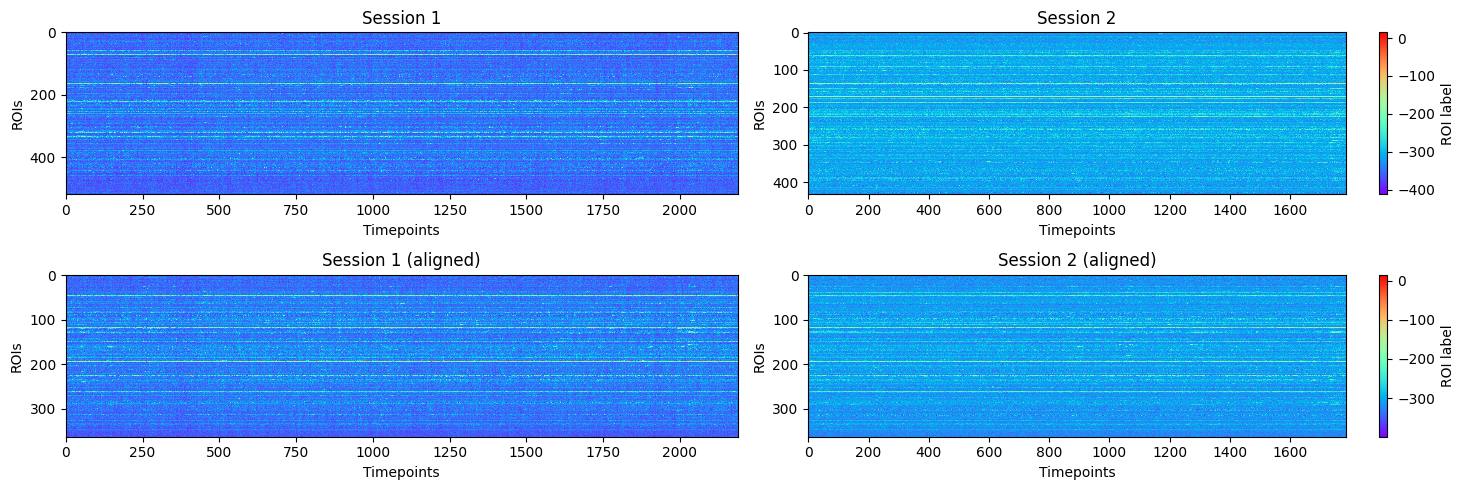

In [5]:
n_sessions = 2   # number of sessions

fig, axs = plt.subplots(2, n_sessions, figsize=(15, 5))
for i in range(n_sessions):
    axs[0, i].imshow(fluorescence_data[i],         aspect="auto", cmap="rainbow", interpolation="none")
    axs[1, i].imshow(data_aligned[i], aspect="auto", cmap="rainbow", interpolation="none")
    axs[0, i].set_title(f"Session {i+1}")
    axs[1, i].set_title(f"Session {i+1} (aligned)")
    axs[0, i].set_xlabel("Timepoints")
    axs[1, i].set_xlabel("Timepoints")
    axs[0, i].set_ylabel("ROIs")
    axs[1, i].set_ylabel("ROIs")
    ## Colorbar
    if i == n_sessions - 1:
        fig.colorbar(axs[0, i].imshow(fluorescence_data[i], aspect="auto", cmap="rainbow", interpolation="none"), ax=axs[0, i], label="ROI label")
        fig.colorbar(axs[1, i].imshow(data_aligned[i], aspect="auto", cmap="rainbow", interpolation="none"), ax=axs[1, i], label="ROI label")
plt.tight_layout()

We can also look at the what the original indices for the aligned data were by passing the 'return_indices' argument:

In [28]:
## Recover original indices

data_aligned, idx_original_aligned = roicat.util.match_arrays_with_ucids(
    arrays=fluorescence_data,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=roi_labels,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
    return_indices=True,  
)

IndexError: list index out of range

The values of `idx_original_aligned` represent the old indices in `data`, whereas the indices in `idx_original_aligned` match the indices in `data_aligned`. Note that the dtype of `idx_original_aligned` is a floating point, because some of the elements are NaNs; these elements represent clusters with no corresponding ROI from that session.

`idx_original_aligned` can be used directly to align any data with indices matching the original data. For example, if you have some metadata associated with each ROI, you can align that metadata using `idx_original_aligned` and the `roicat.helpers.index_with_nans` function.

## 2. Quality control

### a. Applying inclusion criteria

##### Example 1: Remove bad ROIs from labels / UCIDs
For example, you may want to remove ROIs that are not cells. This can be done using the `roicat.util.mask_UCIDs_with_iscell` function.

In [79]:
iscell_list = [r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\1\plane0\iscell.npy", r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\2\plane0\iscell.npy"] # list of planes of iscell data
iscell = []
for npy_file_path in iscell_list:
    data = np.load(npy_file_path)
    list = []
    for d in data:
        if d[0] == 1:
            list.append(True)
        else:
            list.append(False)   # convert the 0/1 & probability in iscell file from suite2p into True or False
    iscell.append(list)  # add all iscell data to a list

In [37]:
n_rois = [np.random.randint(low=300, high=500) for _ in range(n_sessions)]
iscell = [np.random.choice(a=[True, False], size=n, p=[0.5, 0.5]) for n in n_rois]  ## [(n_rois,)] * n_sessions
iscell

[array([False,  True, False, False,  True, False,  True,  True,  True,
         True,  True, False, False, False, False, False, False,  True,
         True,  True, False, False,  True, False, False,  True, False,
         True, False, False, False,  True, False,  True,  True,  True,
         True,  True,  True, False,  True, False, False, False, False,
         True, False,  True,  True,  True, False,  True, False,  True,
         True,  True,  True, False, False, False, False,  True,  True,
         True, False, False, False, False,  True, False,  True, False,
         True,  True,  True, False, False, False,  True, False,  True,
        False,  True, False, False,  True, False, False,  True,  True,
        False, False,  True,  True, False,  True, False,  True,  True,
        False, False,  True,  True,  True,  True,  True, False,  True,
         True,  True, False, False, False, False, False,  True,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,
      

In [85]:
## Apply the mask to the aligned data
labels_iscell = roicat.util.mask_UCIDs_with_iscell(
    ucids=roi_labels,
    iscell=iscell,
)

## Squeeze the labels to remove the unassigned labels (not necessary, but reduces the number of unique labels)
labels_iscell = roicat.util.squeeze_UCID_labels(ucids=labels_iscell, return_array=True)  ## [(n_rois,)] * n_sessions

## Align the data with the masked labels
data_aligned_masked = roicat.util.match_arrays_with_ucids(
    arrays= data_aligned,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=labels_iscell,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
)

## Check the results
print("Original data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data])
print('')
print("First aligned data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data_aligned])
print('')
print("iscell masked aligned data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data_aligned_masked])

IndexError: index 134 is out of bounds for axis 0 with size 99

Note that the number of unique labels has decreased because we have removed some ROIs.

##### Example 2: Remove clusters with few ROIs

You may want to only analyze data from clusters with a minimum number of ROIs. This can be done using the `roicat.util.discard_UCIDs_with_fewer_matches` function.

INFO: 1.89% of UCIDs that appear in at least 3 sessions.


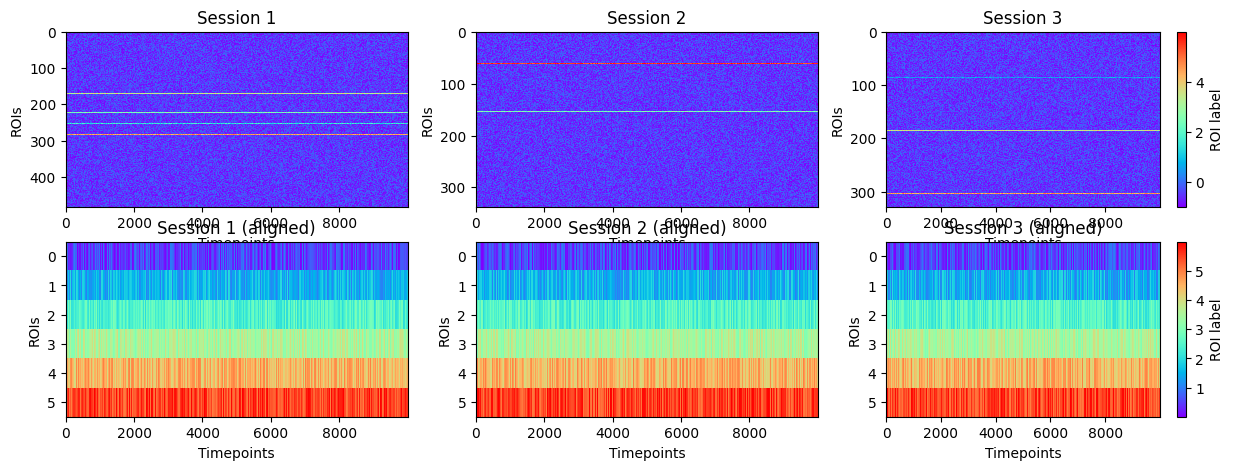

In [8]:
n_sessions_minimum = 3

## Remove labels / UCIDs that are not assigned in at least [n_sessions_minimum] sessions
labels_minSesh = roicat.util.discard_UCIDs_with_fewer_matches(
    ucids=roi_labels,
    n_sesh_thresh=n_sessions_minimum,
)
## Squeeze the labels to remove the unassigned labels (not necessary, but reduces the number of unique labels)
labels_minSesh = roicat.util.squeeze_UCID_labels(ucids=labels_minSesh, return_array=True)  ## [(n_rois,)] * n_sessions

## Align the data with the masked labels
data_aligned_minSesh = roicat.util.match_arrays_with_ucids(
    arrays=data,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=labels_minSesh,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
)

## Visualize the results
data_rainbow_minSesh = [d + r[:, None] for d, r in zip(data, labels_minSesh)]
data_rainbow_aligned_minSesh = roicat.util.match_arrays_with_ucids(
    arrays=data_rainbow_minSesh,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=labels_minSesh,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
)
fig, axs = plt.subplots(2, n_sessions, figsize=(15, 5))
for i in range(n_sessions):
    axs[0, i].imshow(data_rainbow_minSesh[i],         aspect="auto", cmap="rainbow", interpolation="none")
    axs[1, i].imshow(data_rainbow_aligned_minSesh[i], aspect="auto", cmap="rainbow", interpolation="none")
    axs[0, i].set_title(f"Session {i+1}")
    axs[1, i].set_title(f"Session {i+1} (aligned)")
    axs[0, i].set_xlabel("Timepoints")
    axs[1, i].set_xlabel("Timepoints")
    axs[0, i].set_ylabel("ROIs")
    axs[1, i].set_ylabel("ROIs")
    ## Colorbar
    if i == n_sessions - 1:
        fig.colorbar(axs[0, i].imshow(data_rainbow_minSesh[i], aspect="auto", cmap="rainbow", interpolation="none"), ax=axs[0, i], label="ROI label")
        fig.colorbar(axs[1, i].imshow(data_rainbow_aligned_minSesh[i], aspect="auto", cmap="rainbow", interpolation="none"), ax=axs[1, i], label="ROI label")

Note that the number of unique labels has decreased significantly because we have removed clusters with fewer than `n_sessions_minimum` ROIs. Also note that there are fewer rows that are NaNs in the final aligned data, this is because there are fewer labels that = -1 (unclustered ROIs).

##### Example 3: Masking labels / UCIDs by label

You may want to remove specific clusters from the labels / UCIDs. This can be done using the `roicat.util.mask_UCIDs_by_label` function. This is useful for when some clusters are of low quality.

In [33]:
## Define bad cluster labels to remove
labels_keep = np.random.choice(a=np.unique(np.concatenate(roi_labels)), size=80, replace=False)  ## Randomly select 80 labels to keep

print(roi_labels)

## Remove bad cluster labels
labels_masked_keep = roicat.util.mask_UCIDs_by_label(
    ucids=roi_labels,
    labels=labels_keep,
)
## Squeeze the labels to remove the unassigned labels (not necessary, but reduces the number of unique labels)
labels_masked_keep = roicat.util.squeeze_UCID_labels(ucids=labels_masked_keep, return_array=True)  ## [(n_rois,)] * n_sessions

## Align the data with the masked labels
data_aligned_masked_keep = roicat.util.match_arrays_with_ucids(
    arrays=data,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=labels_masked_keep,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
)

## Check the results
print("Original data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data])
print('')
print("First aligned data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data_aligned])
print('')
print("labels_masked_keep aligned data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data_aligned_masked_keep])

[[-1, 2, 0, -1, 1, 5, 9, -1, 6, -1, -1, 14, 8, -1, 12, 3, -1, 4, 11, 17, 10, 15, 7, 20, 19, 31, 34, 23, -1, -1, 22, 16, 18, 26, -1, -1, 32, 13, 27, 24, 21, -1, 46, 43, 40, 39, 35, 37, 36, 29, -1, 28, 44, 50, 25, 53, 38, 30, 52, 41, 47, -1, 45, -1, 51, 56, 48, 42, 33, 57, 62, 54, 64, 55, 69, -1, 61, 59, 49, 71, -1, 63, 60, 66, 75, 67, 70, 74, 78, 68, 58, 79, 73, 87, 83, 76, 65, 81, 80, 77, -1, 92, 85, 100, 88, -1, 72, 102, 98, 93, 112, 84, -1, 97, 115, 114, 118, 113, 90, 108, 109, 105, 95, 89, 82, 106, 116, 101, 103, 94, 107, 110, 86, -1, 96, 91, 120, 117, 123, -1, 99, 130, 122, 111, 125, -1, 135, -1, -1, 104, 140, 126, 133, 131, 124, 119, 127, 147, -1, -1, 128, 143, -1, 144, 132, 121, 141, 136, -1, 145, 152, -1, 129, -1, 142, 139, 148, 149, 153, 151, 137, 154, 134, 138, -1, -1, 150, 155, 159, 161, 146, 165, -1, 170, -1, 157, 162, 160, 171, 156, 167, -1, 173, 164, 174, -1, -1, 166, -1, 158, 175, -1, 169, 181, -1, 168, 172, 184, 188, 177, 179, 180, -1, -1, 185, 183, 163, 190, -1, 176, 18

### b. Quality control metrics

ROICaT tracking provides a number of quality control metrics that can be used to assess the quality of the tracking. These metrics are stored within the `results_clusters.json` file.

In [57]:
results_clusters = roicat.helpers.json_load(filepath="/media/rich/bigSSD/data_tmp/test_data/mouse_1.tracking.results_clusters.json")

print("Items in the results_clusters dictionary:")
[print(f"'{k}'".ljust(25), f"length: {len(v) if hasattr(v, '__len__') else 'N/A'}") for k, v in results_clusters.items()];

print('')

print("Items in the results_clusters['quality_metrics'] dictionary:")
[print(f"'{k}'".ljust(25), f"length: {len(v) if hasattr(v, '__len__') else 'N/A'}") for k, v in results_clusters['quality_metrics'].items()];

Items in the results_clusters dictionary:
'labels'                  length: 7337
'labels_bySession'        length: 3
'labels_dict'             length: 2143
'quality_metrics'         length: 8

Items in the results_clusters['quality_metrics'] dictionary:
'cluster_labels_unique'   length: 2143
'cluster_intra_means'     length: 2143
'cluster_intra_mins'      length: 2143
'cluster_intra_maxs'      length: 2143
'cluster_silhouette'      length: 2143
'sample_silhouette'       length: 7337
'hdbscan'                 length: N/A
'sequentialHungarian'     length: 4


See the [ROICaT documentation](https://roicat.readthedocs.io/en/latest/inputsAndOutputs.html#quality-control) on what each metric means. Set your own thresholds using these metrics and apply inclusion criteria as shown above.

The `'cluster_...'` metrics have length equal to the number of unique labels. These metrics can be used to filter out bad clusters. The `'sample_...'` metrics have length equal to the total number of ROIs across all sessions. These metrics can be used to filter out bad ROIs.